# Make spatial correlations between variables
conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

list_vars = ['tas', 'snc', 'pr', 'ta']
table = [None]*len(list_vars); label = [None]*len(list_vars); units = [None]*len(list_vars); 
cmap = [None]*len(list_vars); levels = [None]*len(list_vars)
for i, var in enumerate(list_vars):
    table[i] = u.get_table(var)
#     label[i], units[i], cmap[i], levels[i] = u.get_var_infos(var)
    label[i], units[i], cmap[i], levels[i], extend, \
        levels_diff, cmap_diff, extend_diff, \
        levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

# With APHRODITE

## Load results

In [4]:
# mmm: multimodel mean (is at the last index)
# It is removed here .isel(model=slice(0,-1))

bias = [None]*len(list_vars)
for i, var in enumerate(list_vars):
    bias[i] = xr.open_dataarray(
        'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
    ).isel(model=slice(0,-1))
    bias[i].name = var

## Create DataFrame to save correlation results

In [5]:
corr_labels = [
    'tas/snc', 'tas/pr', 'snc/pr', 'tas/ta', 
    'tas/elevation', 'snc/elevation', 'pr/elevation',
    'tas/elevation_std', 'snc/elevation_std', 'pr/elevation_std',
]
index_corr = np.array(corr_labels*len(seasons))
index_seasons = np.array([[season]*len(corr_labels) for season in seasons]).flatten()

indexes = [index_seasons, index_corr]

temp = np.empty((indexes[0].size, bias[0].model.size))
temp[:] = np.nan

df = pd.DataFrame(temp, index = indexes, columns = bias[0].model.values)
df

BCC-CSM2-MR  BCC-ESM1  CAS-ESM2-0  CESM2  CESM2-FV2  \
Annual tas/snc                    NaN       NaN         NaN    NaN        NaN   
       tas/pr                     NaN       NaN         NaN    NaN        NaN   
       snc/pr                     NaN       NaN         NaN    NaN        NaN   
       tas/ta                     NaN       NaN         NaN    NaN        NaN   
       tas/elevation              NaN       NaN         NaN    NaN        NaN   
       snc/elevation              NaN       NaN         NaN    NaN        NaN   
       pr/elevation               NaN       NaN         NaN    NaN        NaN   
       tas/elevation_std          NaN       NaN         NaN    NaN        NaN   
       snc/elevation_std          NaN       NaN         NaN    NaN        NaN   
       pr/elevation_std           NaN       NaN         NaN    NaN        NaN   
DJFMA  tas/snc                    NaN       NaN         NaN    NaN        NaN   
       tas/pr                     NaN       NaN         NaN    NaN        NaN   
       snc/pr                     NaN       NaN         NaN    NaN        NaN   
       tas/ta                     NaN       NaN         NaN    NaN        NaN   
       tas/elevation              NaN       NaN         NaN    NaN        NaN   
       snc/elevation              NaN       NaN         NaN    NaN        NaN   
       pr/elevation               NaN       NaN         NaN    NaN        NaN   
       tas/elevation_std          NaN       NaN         NaN    NaN        NaN   
       snc/elevation_std          NaN       NaN         NaN    NaN        NaN   
       pr/elevation_std           NaN       NaN         NaN    NaN        NaN   
JJAS   tas/snc                    NaN       NaN         NaN    NaN        NaN   
       tas/pr                     NaN       NaN         NaN    NaN        NaN   
       snc/pr                     NaN       NaN         NaN    NaN        NaN   
       tas/ta                     NaN       NaN         NaN    NaN        NaN   
       tas/elevation              NaN       NaN         NaN    NaN        NaN   
       snc/elevation              NaN       NaN         NaN    NaN        NaN   
       pr/elevation               NaN       NaN         NaN    NaN        NaN   
       tas/elevation_std          NaN       NaN         NaN    NaN        NaN   
       snc/elevation_std          NaN       NaN         NaN    NaN        NaN   
       pr/elevation_std           NaN       NaN         NaN    NaN        NaN   

                          CESM2-WACCM  CESM2-WACCM-FV2  CNRM-CM6-1  \
Annual tas/snc                    NaN              NaN         NaN   
       tas/pr                     NaN              NaN         NaN   
       snc/pr                     NaN              NaN         NaN   
       tas/ta                     NaN              NaN         NaN   
       tas/elevation              NaN              NaN         NaN   
       snc/elevation              NaN              NaN         NaN   
       pr/elevation               NaN              NaN         NaN   
       tas/elevation_std          NaN              NaN         NaN   
       snc/elevation_std          NaN              NaN         NaN   
       pr/elevation_std           NaN              NaN         NaN   
DJFMA  tas/snc                    NaN              NaN         NaN   
       tas/pr                     NaN              NaN         NaN   
       snc/pr                     NaN              NaN         NaN   
       tas/ta                     NaN              NaN         NaN   
       tas/elevation              NaN              NaN         NaN   
       snc/elevation              NaN              NaN         NaN   
       pr/elevation               NaN              NaN         NaN   
       tas/elevation_std          NaN              NaN         NaN   
       snc/elevation_std          NaN              NaN         NaN   
       pr/elevation_std           NaN              NaN         NaN   
JJAS   tas/snc                    NaN       

In [23]:
df_pvalue = df.copy()

## Compute correlations

In [6]:
list_vars

['tas', 'snc', 'pr', 'ta']

In [7]:
corr_labels

['tas/snc',
 'tas/pr',
 'snc/pr',
 'tas/ta',
 'tas/elevation',
 'snc/elevation',
 'pr/elevation',
 'tas/elevation_std',
 'snc/elevation_std',
 'pr/elevation_std']

In [8]:
# 0: tas
# 1: snc
# 2: pr
# 3: ta
# 4: elevation
# 5: elevation_std

pairs = [[0, 1], [0, 2], [1, 2], [0, 3], [0, 4], [1, 4], [2, 4], [0, 5], [1, 5], [2, 5]]

In [31]:
%%time
for season in seasons:
# for season in ['Annual']:
    print(season)
    for k, pair in enumerate(pairs):
        print(k)
        for model in bias[0].model.values:
#             print(model)
                
            # Get all values for HMA (>2500m) and flatten the values
            x = bias[pair[0]].sel(season=season, model=model).where(elevation > 2500).values.flatten()
            
            if pair[1] in [4, 5]:
                if pair[1] == 4:
                    y = elevation.sel(lat=latlim, lon=lonlim).where(elevation > 2500).values.flatten()
                elif pair[1] == 5:
                    y = elevation_std.sel(lat=latlim, lon=lonlim).where(elevation > 2500).values.flatten()
            else:
                y = bias[pair[1]].sel(season=season, model=model).where(elevation > 2500).values.flatten()
    
            # Remove the nans
#             print(len(x))
#             print(len(y))
            if len(x) <= len(y):
                temp = x
            else:
                temp = y
            x = x[~np.isnan(temp)]
            y = y[~np.isnan(temp)]

            # Get rvalue
            df.loc[season, corr_labels[k]][model] = stats.linregress(x, y).rvalue
            df_pvalue.loc[season, corr_labels[k]][model] = stats.linregress(x, y).pvalue

Annual
0
1
2
3
4
5
6
7
8
9
DJFMA
0
1
2
3
4
5
6
7
8
9
JJAS
0
1
2
3
4
5
6
7
8
9
CPU times: user 8.9 s, sys: 32 ms, total: 8.94 s
Wall time: 8.92 s


## Heatmap

In [35]:
df.loc[seasons[i]].where(df_pvalue.loc[seasons[i]] < 0.05)

,BCC-CSM2-MR,BCC-ESM1,CAS-ESM2-0,CESM2,CESM2-FV2,CESM2-WACCM,CESM2-WACCM-FV2,CNRM-CM6-1,CNRM-CM6-1-HR,CNRM-ESM2-1,...,IPSL-CM6A-LR,MIROC-ES2L,MIROC6,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NorESM2-LM,SAM0-UNICON,TaiESM1,UKESM1-0-LL
tas/snc,-0.429670,-0.401357,-0.135601,0.219013,NaN,0.219359,NaN,-0.493905,-0.544834,-0.429583,...,-0.740077,-0.533613,-0.426523,0.244977,NaN,NaN,-0.163935,0.235102,0.149124,-0.322754
tas/pr,NaN,-0.281407,NaN,NaN,-0.176511,NaN,-0.183024,NaN,NaN,NaN,...,0.134255,-0.275199,-0.128540,-0.399158,-0.391788,NaN,-0.275244,-0.124342,-0.193327,NaN
snc/pr,-0.119236,0.271965,0.452717,NaN,0.121149,NaN,0.129304,-0.119806,-0.206066,NaN,...,NaN,0.210259,NaN,NaN,NaN,NaN,0.239574,0.243170,NaN,NaN
tas/ta,0.341913,-0.152686,0.586506,NaN,-0.208443,NaN,-0.209513,0.571073,0.616001,0.511252,...,0.697589,-0.457650,0.446211,0.197202,0.108800,0.444011,-0.169527,NaN,-0.349535,NaN
tas/elevation,-0.366392,NaN,-0.355861,NaN,0.110552,NaN,0.135871,-0.389407,-0.367124,-0.344491,...,-0.565231,-0.184464,-0.514753,-0.349777,-0.236057,-0.298784,NaN,-0.277472,-0.319336,-0.177095
snc/elevation,0.473457,0.137782,0.453714,NaN,NaN,NaN,NaN,0.598872,0.644060,0.538881,...,0.546592,0.182486,0.410025,NaN,NaN,0.424309,NaN,NaN,0.126151,0.699879
pr/elevation,0.110505,0.244260,0.242836,-0.110393,NaN,NaN,NaN,NaN,-0.287369,NaN,...,NaN,NaN,NaN,0.134538,0.206863,0.200141,NaN,NaN,NaN,0.107060
tas/elevation_std,0.261749,0.234035,NaN,NaN,NaN,NaN,NaN,0.141351,-0.106600,NaN,...,0.182414,0.301413,0.328300,NaN,0.123822,NaN,0.162293,0.114787,0.109486,0.190046
snc/elevation_std,-0.527173,-0.500474,-0.460097,-0.466916,-0.446389,-0.463212,-0.444918,-0.410096,-0.276338,-0.409526,...,-0.198778,-0.544747,-0.585075,-0.478321,-0.466526,-0.623639,-0.446826,-0.467152,-0.469311,-0.668261
pr/elevation_std,0.198412,-0.207689,-0.177572,0.247551,NaN,0.275312,NaN,0.147792,0.360301,0.169786,...,0.184895,-0.143014,0.237650,0.195144,NaN,NaN,NaN,NaN,0.407547,NaN


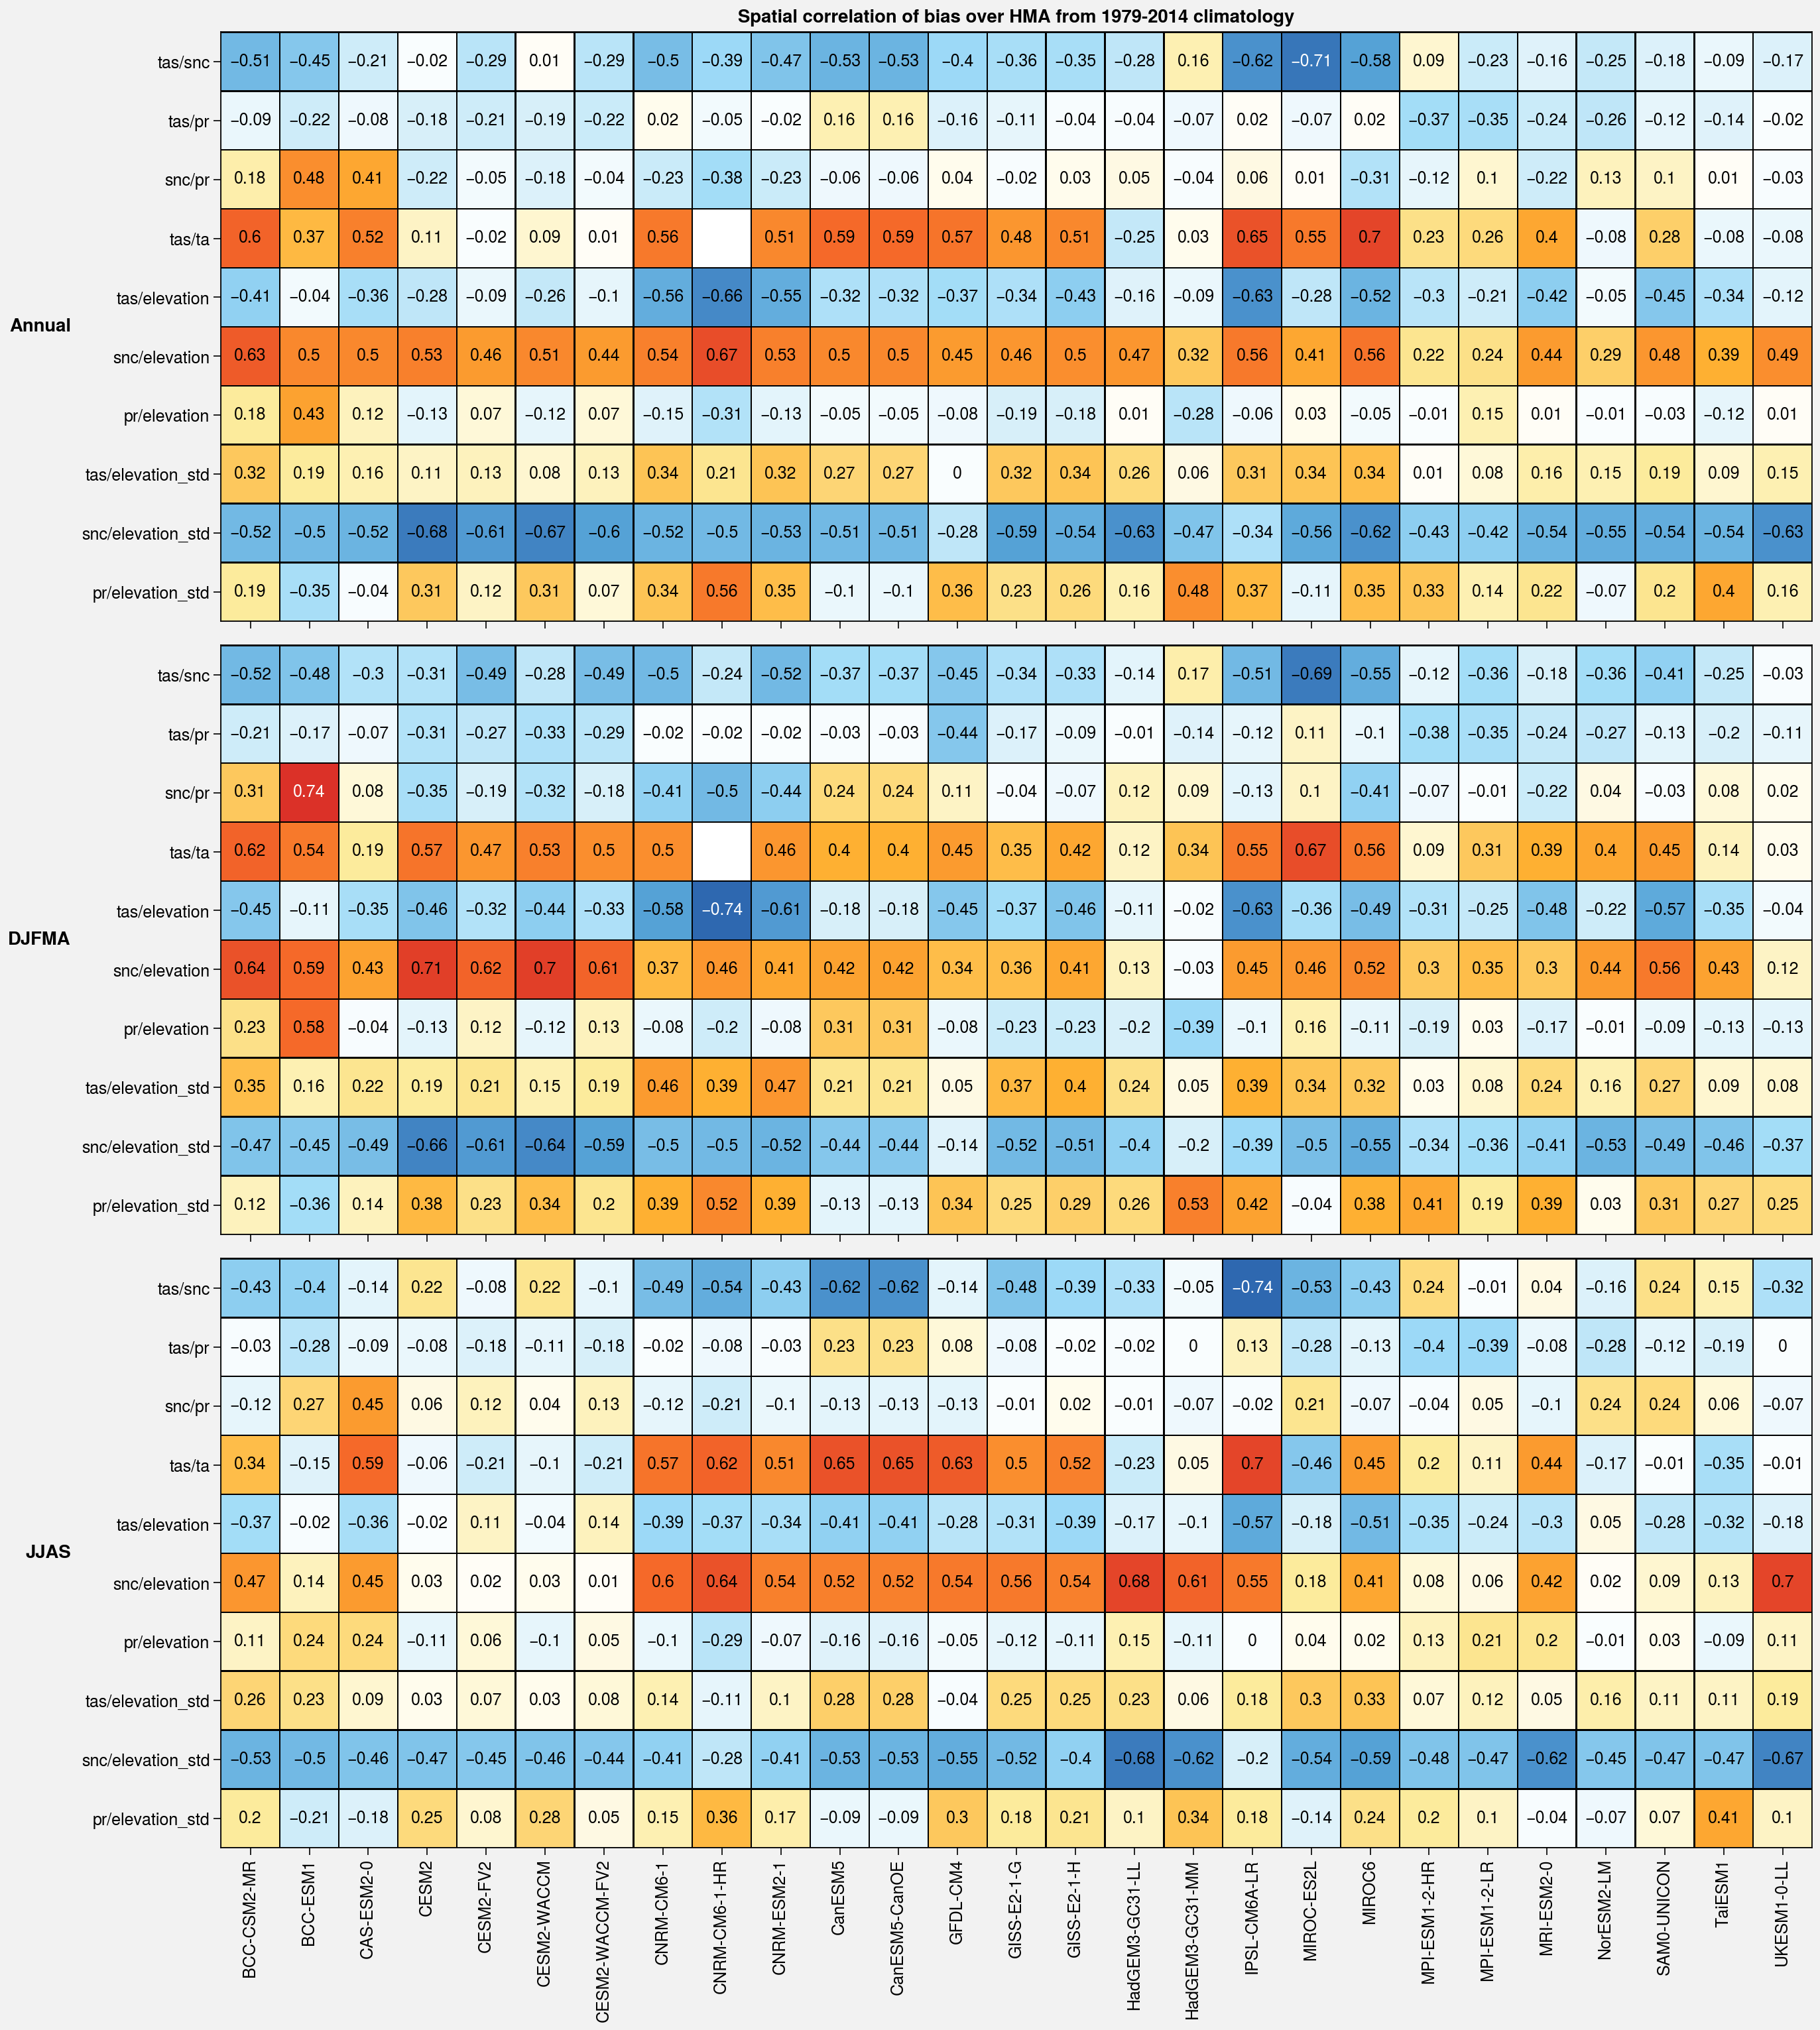

In [38]:
fig, axs = plot.subplots(nrows=3, ncols=1, axwidth=12)

for i, ax in enumerate(axs):
    ax.heatmap(
        df.loc[seasons[i]], 
#         df.loc[seasons[i]].where(df_pvalue.loc[seasons[i]] < 0.05), 
        cmap='ColdHot', vmin=-1, vmax=1, N=100,
        lw=0.5, edgecolor='k', labels=True,
    )
    

axs.format(
    xrotation=90, rowlabels=seasons, yreverse=True,
    suptitle='Spatial correlation of bias over HMA from '+period.start+'-'+period.stop+' climatology', 
#     ticklabelsize=10, suptitlesize=11, title=' '
)

filename = 'correlation_ext_bias_'+period.start+'-'+period.stop
fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')

## Redo with GPCP

## Load results

In [14]:
# mmm: multimodel mean (is at the last index)
# It is removed here .isel(model=slice(0,-1))

bias = [None]*len(list_vars)
for i, var in enumerate(list_vars):
    if var == 'pr':
        bias[i] = xr.open_dataarray(
            'results/'+var+'_GPCP_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
        ).isel(model=slice(0,-1))
    else:
        bias[i] = xr.open_dataarray(
            'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
        ).isel(model=slice(0,-1))
    bias[i].name = var

## Create DataFrame to save correlation results

In [15]:
corr_labels = ['tas/snc', 'tas/pr', 'snc/pr']
index_corr = np.array(corr_labels*len(seasons))
index_seasons = np.array([[season]*len(corr_labels) for season in seasons]).flatten()

indexes = [index_seasons, index_corr]

temp = np.empty((indexes[0].size, bias[0].model.size))
temp[:] = np.nan

df = pd.DataFrame(temp, index = indexes, columns = bias[0].model.values)
df

BCC-CSM2-MR  BCC-ESM1  CAS-ESM2-0  CESM2  CESM2-FV2  \
Annual tas/snc          NaN       NaN         NaN    NaN        NaN   
       tas/pr           NaN       NaN         NaN    NaN        NaN   
       snc/pr           NaN       NaN         NaN    NaN        NaN   
DJFMA  tas/snc          NaN       NaN         NaN    NaN        NaN   
       tas/pr           NaN       NaN         NaN    NaN        NaN   
       snc/pr           NaN       NaN         NaN    NaN        NaN   
JJAS   tas/snc          NaN       NaN         NaN    NaN        NaN   
       tas/pr           NaN       NaN         NaN    NaN        NaN   
       snc/pr           NaN       NaN         NaN    NaN        NaN   

                CESM2-WACCM  CESM2-WACCM-FV2  CNRM-CM6-1  CNRM-CM6-1-HR  \
Annual tas/snc          NaN              NaN         NaN            NaN   
       tas/pr           NaN              NaN         NaN            NaN   
       snc/pr           NaN              NaN         NaN            NaN   
DJFMA  tas/snc          NaN              NaN         NaN            NaN   
       tas/pr           NaN              NaN         NaN            NaN   
       snc/pr           NaN              NaN         NaN            NaN   
JJAS   tas/snc          NaN              NaN         NaN            NaN   
       tas/pr           NaN              NaN         NaN            NaN   
       snc/pr           NaN              NaN         NaN            NaN   

                CNRM-ESM2-1  ...  IPSL-CM6A-LR  MIROC-ES2L  MIROC6  \
Annual tas/snc          NaN  ...           NaN         NaN     NaN   
       tas/pr           NaN  ...           NaN         NaN     NaN   
       snc/pr           NaN  ...           NaN         NaN     NaN   
DJFMA  tas/snc          NaN  ...           NaN         NaN     NaN   
       tas/pr           NaN  ...           NaN         NaN     NaN   
       snc/pr           NaN  ...           NaN         NaN     NaN   
JJAS   tas/snc          NaN  ...           NaN         NaN     NaN   
       tas/pr           NaN  ...           NaN         NaN     NaN   
       snc/pr           NaN  ...           NaN         NaN     NaN   

                MPI-ESM1-2-HR  MPI-ESM1-2-LR  MRI-ESM2-0  NorESM2-LM  \
Annual tas/snc            NaN            NaN         NaN         NaN   
       tas/pr             NaN            NaN         NaN         NaN   
       snc/pr             NaN            NaN         NaN         NaN   
DJFMA  tas/snc            NaN            NaN         NaN         NaN   
       tas/pr             NaN            NaN         NaN         NaN   
       snc/pr             NaN            NaN         NaN         NaN   
JJAS   tas/snc            NaN            NaN         NaN         NaN   
       tas/pr             NaN            NaN         NaN         NaN   
       snc/pr             NaN            NaN         NaN         NaN   

                SAM0-UNICON  TaiESM1  UKESM1-0-LL  
Annual tas/snc          NaN      NaN          NaN  
       tas/pr           NaN      NaN          NaN  
       snc/pr           NaN      NaN          NaN  
DJFMA  tas/snc          NaN      NaN          NaN  
       tas/pr           NaN      NaN          NaN  
       snc/pr           NaN      NaN          NaN  
JJAS   tas/snc          NaN      NaN          NaN  
       tas/pr           NaN      NaN          NaN  
       snc/pr           NaN      NaN          NaN  

[9 rows x 27 columns]

## Compute correlations

In [16]:
list_vars

['tas', 'snc', 'pr']

In [17]:
corr_labels

['tas/snc', 'tas/pr', 'snc/pr']

In [18]:
pairs = [[0, 1], [0, 2], [1, 2]]

In [19]:
%%time
for season in seasons:
# for season in ['Annual']:
    print(season)
    for k, pair in enumerate(pairs):
        print(corr_labels)
        print(k)
        for model in bias[0].model.values:
#             print(model)
            # Get all values for HMA (>2500m) and flatten the values
            x = bias[pair[0]].sel(season=season, model=model).where(elevation > 2500).values.flatten()
            y = bias[pair[1]].sel(season=season, model=model).where(elevation > 2500).values.flatten()

            # Remove the nans
            x = x[~np.isnan(x)]
            y = y[~np.isnan(y)]

            # Get rvalue
            df.loc[season, corr_labels[k]][model] = stats.linregress(x, y).rvalue

Annual
['tas/snc', 'tas/pr', 'snc/pr']
0
['tas/snc', 'tas/pr', 'snc/pr']
1
['tas/snc', 'tas/pr', 'snc/pr']
2
DJFMA
['tas/snc', 'tas/pr', 'snc/pr']
0
['tas/snc', 'tas/pr', 'snc/pr']
1
['tas/snc', 'tas/pr', 'snc/pr']
2
JJAS
['tas/snc', 'tas/pr', 'snc/pr']
0
['tas/snc', 'tas/pr', 'snc/pr']
1
['tas/snc', 'tas/pr', 'snc/pr']
2
CPU times: user 2.47 s, sys: 0 ns, total: 2.47 s
Wall time: 2.52 s


## Heatmap

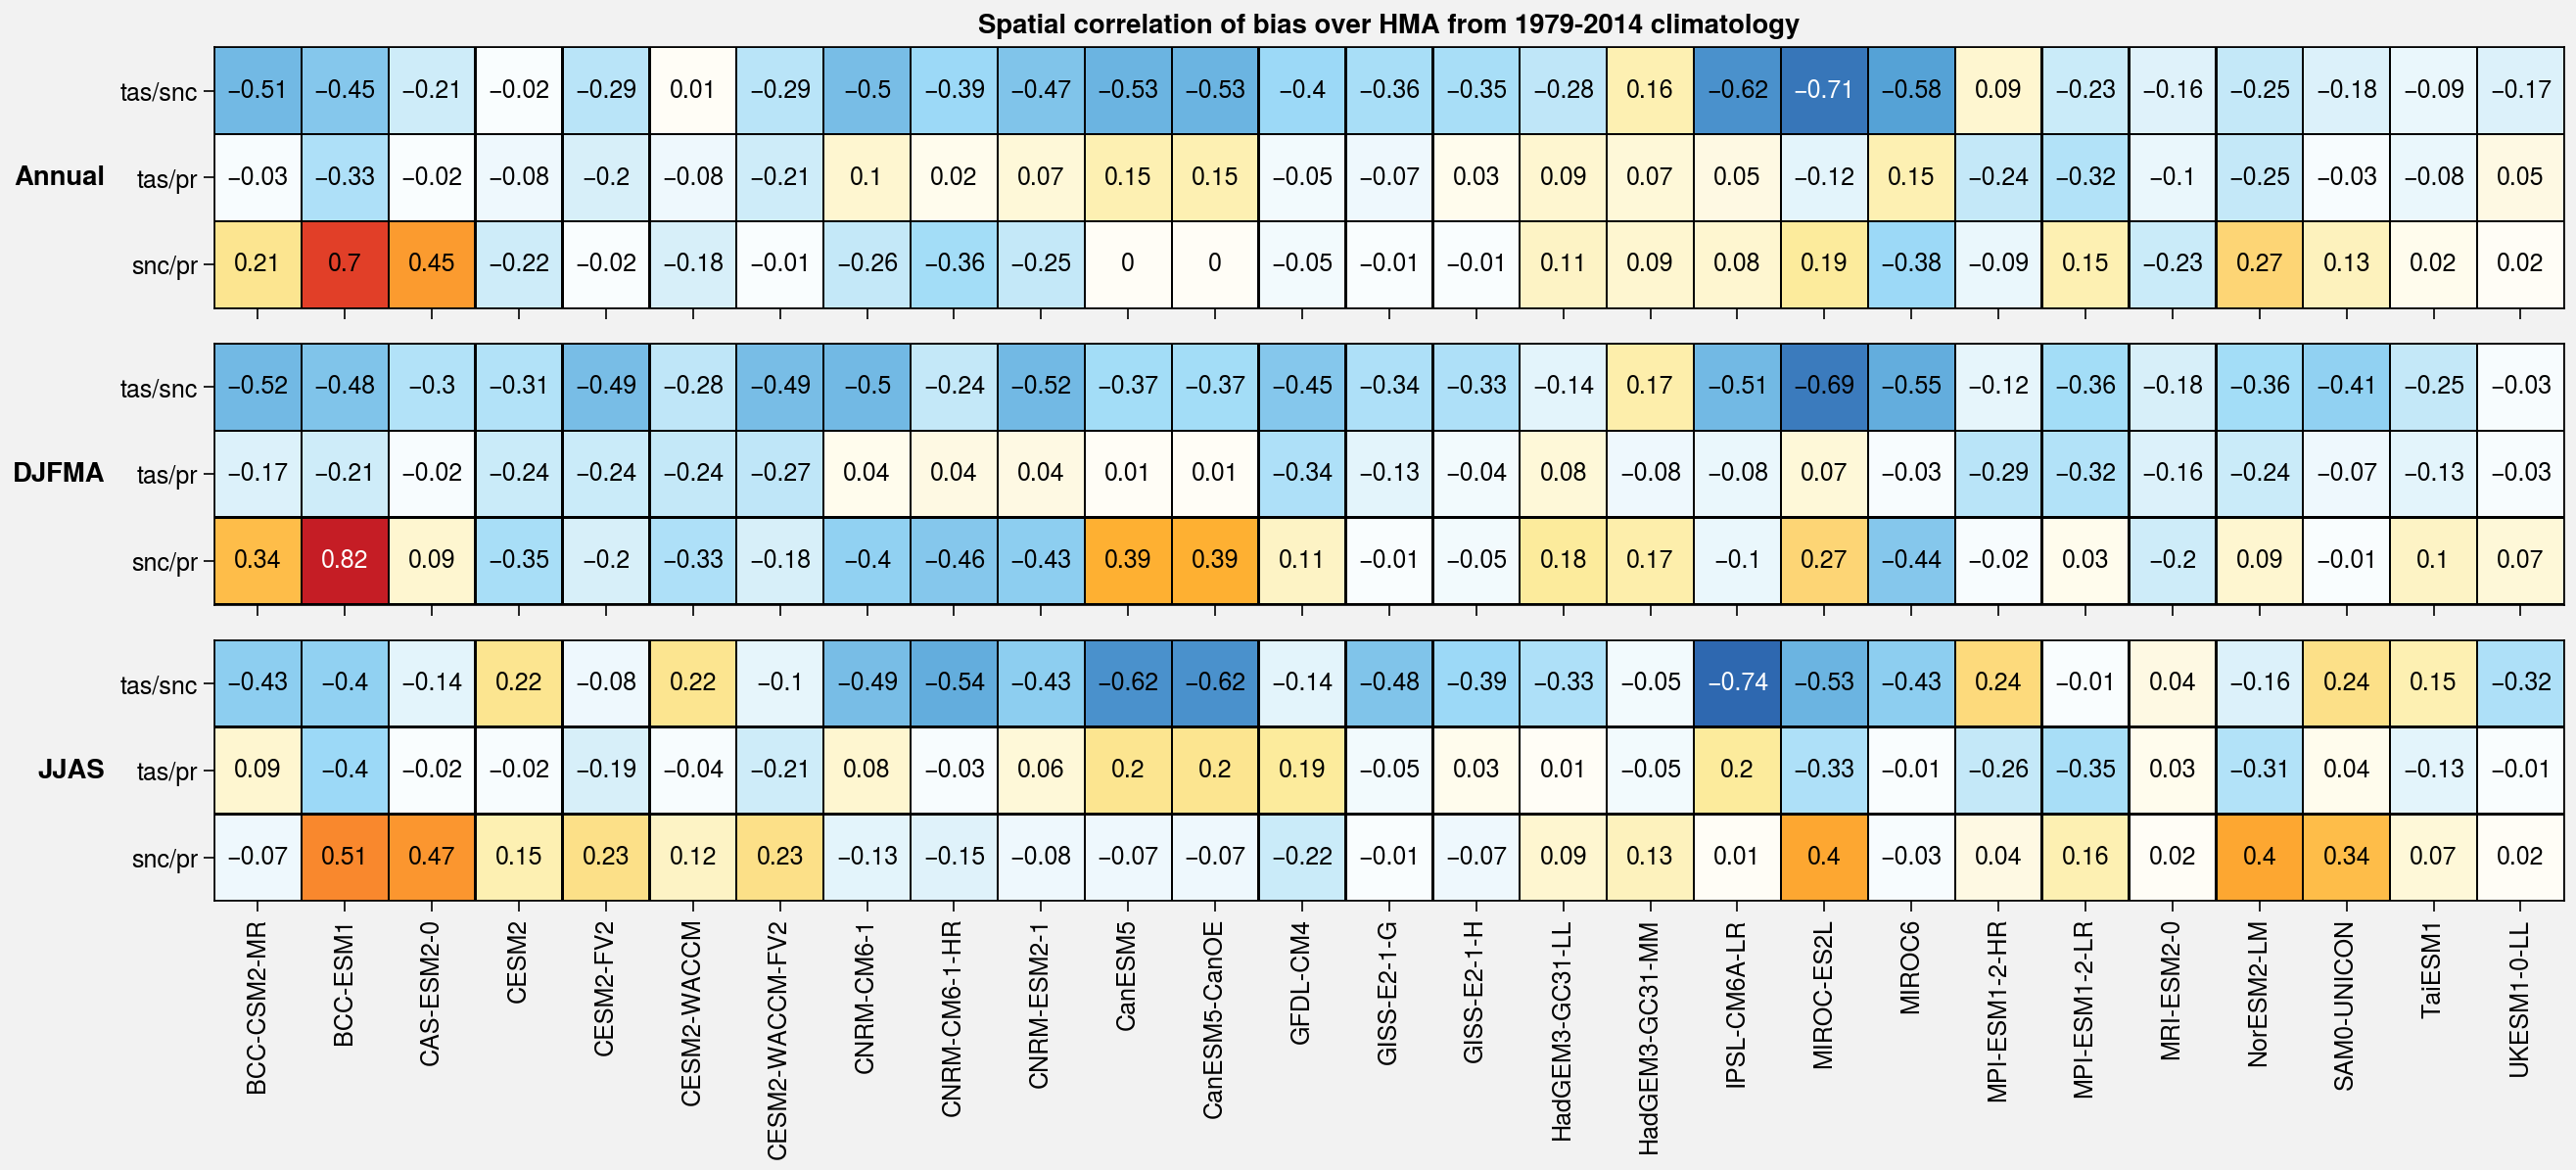

In [21]:
fig, axs = plot.subplots(nrows=3, ncols=1, axwidth=12)

for i, ax in enumerate(axs):
    ax.heatmap(
        df.loc[seasons[i]], 
        cmap='ColdHot', vmin=-1, vmax=1, N=100,
        lw=0.5, edgecolor='k', labels=True,
    )

axs.format(
    xrotation=90, rowlabels=seasons, yreverse=True,
    suptitle='Spatial correlation of bias over HMA from '+period.start+'-'+period.stop+' climatology', 
#     ticklabelsize=10, suptitlesize=11, title=' '
)

filename = 'correlation_bias_GPCP_'+period.start+'-'+period.stop
fig.save('img/'+filename+'.jpg'); fig.save('img/'+filename+'.png'); fig.save('img/'+filename+'.pdf')